In [1]:
import os, io, shutil
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sampler import MultiSampler
from tqdm.autonotebook import tqdm

import numpy as np
from tensorboardX import SummaryWriter
from dataloader.handhygiene import HandHygiene
from spatial_transforms import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, RandomAffine, #ExtractSkinColor,
    RandomRotation, ColorJitter, ToTensor)
from temporal_transforms import (
    MirrorPadding, LoopPadding, TemporalBeginCrop, 
    TemporalRandomCrop, TemporalCenterCrop, TemporalRandomChoice)
from openpose_transforms import CropTorso, MultiScaleTorsoRandomCrop

import logging

/usr/local/lib/python3.5/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
model_name = 'i3d'
batch_size = 16
clip_len = 16
sample_duration = clip_len
num_classes = 1

#torch.manual_seed(100)
data_name = 'anesthesia'
dataset_path = os.path.join(os.getcwd(), 'data')
logging.basicConfig(filename='transforms.log', filemode='w',
                   format='%(message)s', level=logging.INFO)

In [3]:
scales = 1.0
sample_size = 224
mean=[110.63666788, 103.16065604, 96.29023126]
std=[38.7568578, 37.88248729, 40.02898126]
#mean=[128, 128, 128]
#std=[128, 128, 128]

scales=np.linspace(1, 1.75, num=1e4)
openpose_transform = {
    'train':MultiScaleTorsoRandomCrop(scales, sample_size),
    'val':MultiScaleTorsoRandomCrop(np.linspace(1.4, 1.4, num=1), sample_size)}
spatial_transform = {
    'train': Compose([
            Scale(sample_size),
            CenterCrop(sample_size),
            RandomHorizontalFlip(),
            ColorJitter(brightness=0.1),
            RandomAffine(5),
            RandomRotation(5),
            ToTensor(1), 
            Normalize(mean, std)
    ]),
    'val': Compose([Scale(sample_size), CenterCrop(sample_size), 
                    ToTensor(1), Normalize(mean, std)])}
temporal_transform = {
    'train': TemporalRandomChoice([
            TemporalBeginCrop(sample_duration),
            #TemporalRandomCrop(sample_duration),
            #TemporalCenterCrop(sample_duration),
            #LoopPadding(sample_duration),
            MirrorPadding(sample_duration)]),
    'val':TemporalCenterCrop(sample_duration)}

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [4]:
dataset = {
    'train':HandHygiene(dataset_path, split='train', clip_len=clip_len, 
                        spatial_transform=spatial_transform['train'],
                        openpose_transform=openpose_transform['train'],
                        temporal_transform=temporal_transform['train'], num_workers=16),
    'val':HandHygiene(dataset_path, split='val', clip_len=clip_len, 
                        spatial_transform=spatial_transform['val'],
                        openpose_transform=openpose_transform['val'],
                        temporal_transform=temporal_transform['val'], num_workers=16)}

dataloaders = {
    # sampler=MultiSampler(dataset['train'], length*10),
    'train': DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, num_workers=16),
    'val': DataLoader(dataset['val'], batch_size=batch_size, shuffle=False, num_workers=16)}

Number of /data/private/minjee-video/handhygiene/data/images/train videos: 2100
Number of /data/private/minjee-video/handhygiene/data/images/train people: 1981
Number of /data/private/minjee-video/handhygiene/data/images/val videos: 107
Number of /data/private/minjee-video/handhygiene/data/images/val people: 103


In [5]:
from train import get_models
from train import train
from torchsummary import summary

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python

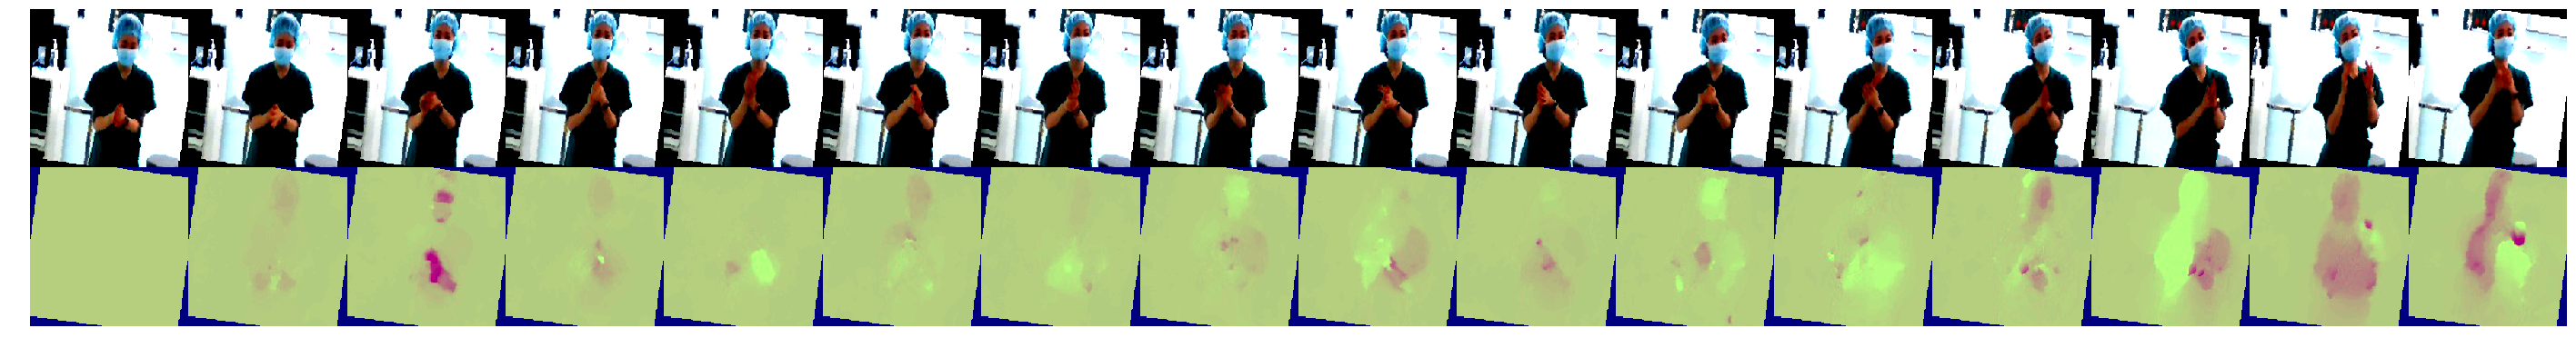

tensor([0])
/data/private/minjee-video/handhygiene/data/images/train/clean/38_20190119_frames000213


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_dataset(item): # item: C x D x 244 x 244
    rgbs = item[0].transpose(0, 1)
    flows = item[1].transpose(0, 1)
    n = len(rgbs)
    shape = np.asarray(flows[0]).shape
    rgb = np.hstack((np.asarray(rgb).transpose(1, 2, 0)+1)/2 for rgb in rgbs)
    #gray = np.hstack((np.squeeze(np.asarray(gray))+1)/2 for gray in rgbs)
    tmp = np.zeros((shape[1], shape[2], 1))
    flow = np.hstack((np.dstack((np.asarray(flow).transpose(1, 2, 0), tmp))+1)/2 for flow in flows)

    img = np.vstack((rgb, flow))
    plt.figure(figsize=(50, 10))
    plt.imshow(img)
    #plt.imshow(gray)
    plt.axis('off')
    plt.show()
    print(item[2])

i=50
phase='train'
show_dataset(dataset[phase].__getitem__(i))
print(dataset[phase].__getpath__(i))

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
i3d_rgb, i3d_flow = get_models(num_classes, True, 170, load_pt_weights=True) # unfreeze last mix 170, 152
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    i3d_rgb = nn.DataParallel(i3d_rgb)
    i3d_flow = nn.DataParallel(i3d_flow)
i3d_rgb.to(device)
i3d_flow.to(device)

criterion = F.binary_cross_entropy
optims={'rgb':None, 'flow':None}
schedulers = {'rgb':None, 'flow':None}
feature_extract=True

Let's use 2 GPUs!


In [8]:
def trainable_params(model, mode='rgb'):
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)
    optims[mode] = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9, weight_decay=1e-7)

trainable_params(i3d_rgb, 'rgb')
trainable_params(i3d_flow, 'flow')
    
schedulers['rgb'] = MultiStepLR(optims['rgb'], milestones=[200,275], gamma=0.1)
schedulers['flow'] = MultiStepLR(optims['flow'], milestones=[300,375], gamma=0.1)

Params to learn:
	 module.conv3d_0c_1x1.0.conv3d.weight
	 module.conv3d_0c_1x1.0.conv3d.bias
	 module.conv3d_0c_1x1.1.conv3d.weight
	 module.conv3d_0c_1x1.1.conv3d.bias
Params to learn:
	 module.conv3d_0c_1x1.0.conv3d.weight
	 module.conv3d_0c_1x1.0.conv3d.bias
	 module.conv3d_0c_1x1.1.conv3d.weight
	 module.conv3d_0c_1x1.1.conv3d.bias


# summary(i3d_rgb, (3, 16, 224, 224))

In [9]:
logging.info("train start......")
train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)

  0%|          | 0/400 [00:00<?, ?it/s]--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.mess

TypeError: not all arguments converted during string formatting
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
TypeError: not all arguments converted during string formatting
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
Call stack:
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch

  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in s

  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args,

  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in n

  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/l

  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_r

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packag

  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train


  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
   

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
Message: 466
Arguments: (TemporalRandomChoice(
),)
Message: 1403
Arguments: (TemporalRandomChoice(
),)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/lib/python3.5/dist-packa

  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File

  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner


  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self.

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.p

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
Message: 1704
Arguments: (TemporalRandomChoice(
),)
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.tempora

TypeError: not all arguments converted during string formatting
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
Call stack:
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInterac

Call stack:
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.5/logging/__init__.py", line 330, i

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelba

  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
  File "/usr/lib/python3.5/asyncio/base_event

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/data/private/minjee-video/handhygi

  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/loca

TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
Message: 98
Arguments: (TemporalRandomChoice(
),)
  File "/usr/local/lib/python3.5/dist-packages/IP

  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848,

  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line

  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/

  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
Message: 1016
Arguments: (TemporalRandomChoice(
),)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/datalo

  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
Message: 1435
Arguments: (TemporalRandomChoice(
),)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <mo

  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/usr/lib/pytho

  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream

  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self.

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
Message: 1735
Arguments: (TemporalRandomChoice(
),)
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
Typ

TypeError: not all arguments converted during string formatting
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
Call stack:
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in 

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
Message: 986
Arguments: (TemporalRandomChoice(
),)
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)

  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib

  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop

  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
--- Logging error ---
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
Traceback (most recent call last):
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.sock

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.p

Call stack:
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
--- Logging error ---
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
Traceback (most recent call last):
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", 

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execu

  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
--- Logging error ---
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=

  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    se

  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio

  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, i

  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/di

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", lin

Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runne

  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "<ipython-input-9-cfe27a6965c4>", line 2,

  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.5/multiprocessing

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactive

  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
Message: 889
Arguments: (TemporalRandomChoice(
),)
--- Logging error ---
Traceb

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/lib/python3.5/dist-packa

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", 

Call stack:
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/loc

  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    c

  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
Message: 448
Arguments: (TemporalRandomChoice(
),)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/data

  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
TypeError: not all arguments converted during string formatting
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
Call stack:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.sta

  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell

  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
Message: 122
Arguments: (TemporalRandomChoice(
),)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, 

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
Message: 114
Arguments: (TemporalRandomChoice(
),)
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)

  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib

  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/m

Traceback (most recent call last):
Message: 21
Arguments: (TemporalRandomChoice(
),)
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
 

  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel

  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/li

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] f

  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Message: 453
Arguments: (TemporalRandomChoice(
),)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in 

  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/mu

  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio

  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, i

  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/di

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", lin

  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
--- Logging error ---
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
Traceback (most recent call last):
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._

  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
Message: 276
Arguments: (TemporalRandomChoice(
),)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
--- Logging error ---
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset

  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
--- Logging error ---
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
Traceback (most recent call last):
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in 

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
Message: 1411
Arguments: (TemporalRandomChoice(
)

  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
--- Logging error ---
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.5/di

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/lib/python3.5/dist-packa

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", 

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_foreve

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
Message: 556
Arguments: (TemporalRandomChoice(
),)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/

  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_f

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
Message: 790
Arguments: (TemporalRandomChoice(
),)
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = recor

  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
--- Logging error ---
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "

  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
Message: 761
Arguments: (TemporalRandomChoice(
),)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/pyt

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
Message: 1260
Arguments: (TemporalRandomChoice(
),)
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec

  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib

  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
Call stack:
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/i

  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
Message: 933
Arguments: (TemporalRandomChoice(
),)
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 1

  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/

  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessin

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python

  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, *

  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/mu

Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
TypeError: not all arguments converted during string formatting
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
Call stack:
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/l

  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
TypeError: not all arguments converted during string formatting
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
Call stack:
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/runpy

  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
TypeError: not all arguments converted during string formatting
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
Call stack:
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init_

Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runne

NameError: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 105, in __getitem__
    findices, coords = self.temporal_transform(findices, coords)
  File "/data/private/minjee-video/handhygiene/temporal_transforms.py", line 271, in __call__
    return t(frame_indices, coords)
  File "/data/private/minjee-video/handhygiene/temporal_transforms.py", line 52, in __call__
    out, out_crd = self.__sizecheck__(out, out_crd)
  File "/data/private/minjee-video/handhygiene/temporal_transforms.py", line 36, in __sizecheck__
    out, out_crd = transforms(out, out_crd)
  File "/data/private/minjee-video/handhygiene/temporal_transforms.py", line 271, in __call__
    return t(frame_indices, coords)
  File "/data/private/minjee-video/handhygiene/temporal_transforms.py", line 143, in __call__
    logging.info("TemporalCenterCrop ")
NameError: name 'logging' is not defined


Message: 1831
Arguments: (TemporalRandomChoice(
),)
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_in

  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
Call stack:
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dis

  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
Message: 857
Arguments: (TemporalRandomChoice(
),)
TypeError: not all arguments converted dur

  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
TypeError: not all arguments converted during string formatting
Message: 1436
Arguments: (TemporalRandomChoice(
),)
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py"

  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, *

  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/mu

  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(pr

  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/loc

  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
--- Logging error ---
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in fo

  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
 

  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambd

  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <l

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", 

  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
--- Logging error ---
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, 

  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    retu

  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    fo

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
Message: 1657
Arguments: (TemporalRandomChoice(
),)
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
Typ

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpe

  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py

  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
Message: 671
Arguments: (TemporalRandomChoice(
),)
--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.messa

  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __

  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-cfe27a6965c4>", line 2, in <module>
    train((i3d_rgb, i3d_flow), dataloaders, optims, criterion, schedulers, device, num_epochs=400)
  File "/data/private/minjee-video/handhygiene/train.py", line 103, in train
    for i, (samples) in enumerate(dataloaders[phase]):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessin

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/data/private/mi

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/data/private/minjee-video/handhygiene/dataloader/handhygiene.py", line 104, in __getitem__
    logging.info(index, self.temporal_transform)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
Message: 1864
Arguments: (TemporalRandomChoice(
),)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asy

  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 819, in __iter__
    return _DataLoaderIter(self)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, i

  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _r

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 560, in __init__
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", lin

Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local

  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runne

  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 212, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.5/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.

  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr